In [1]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


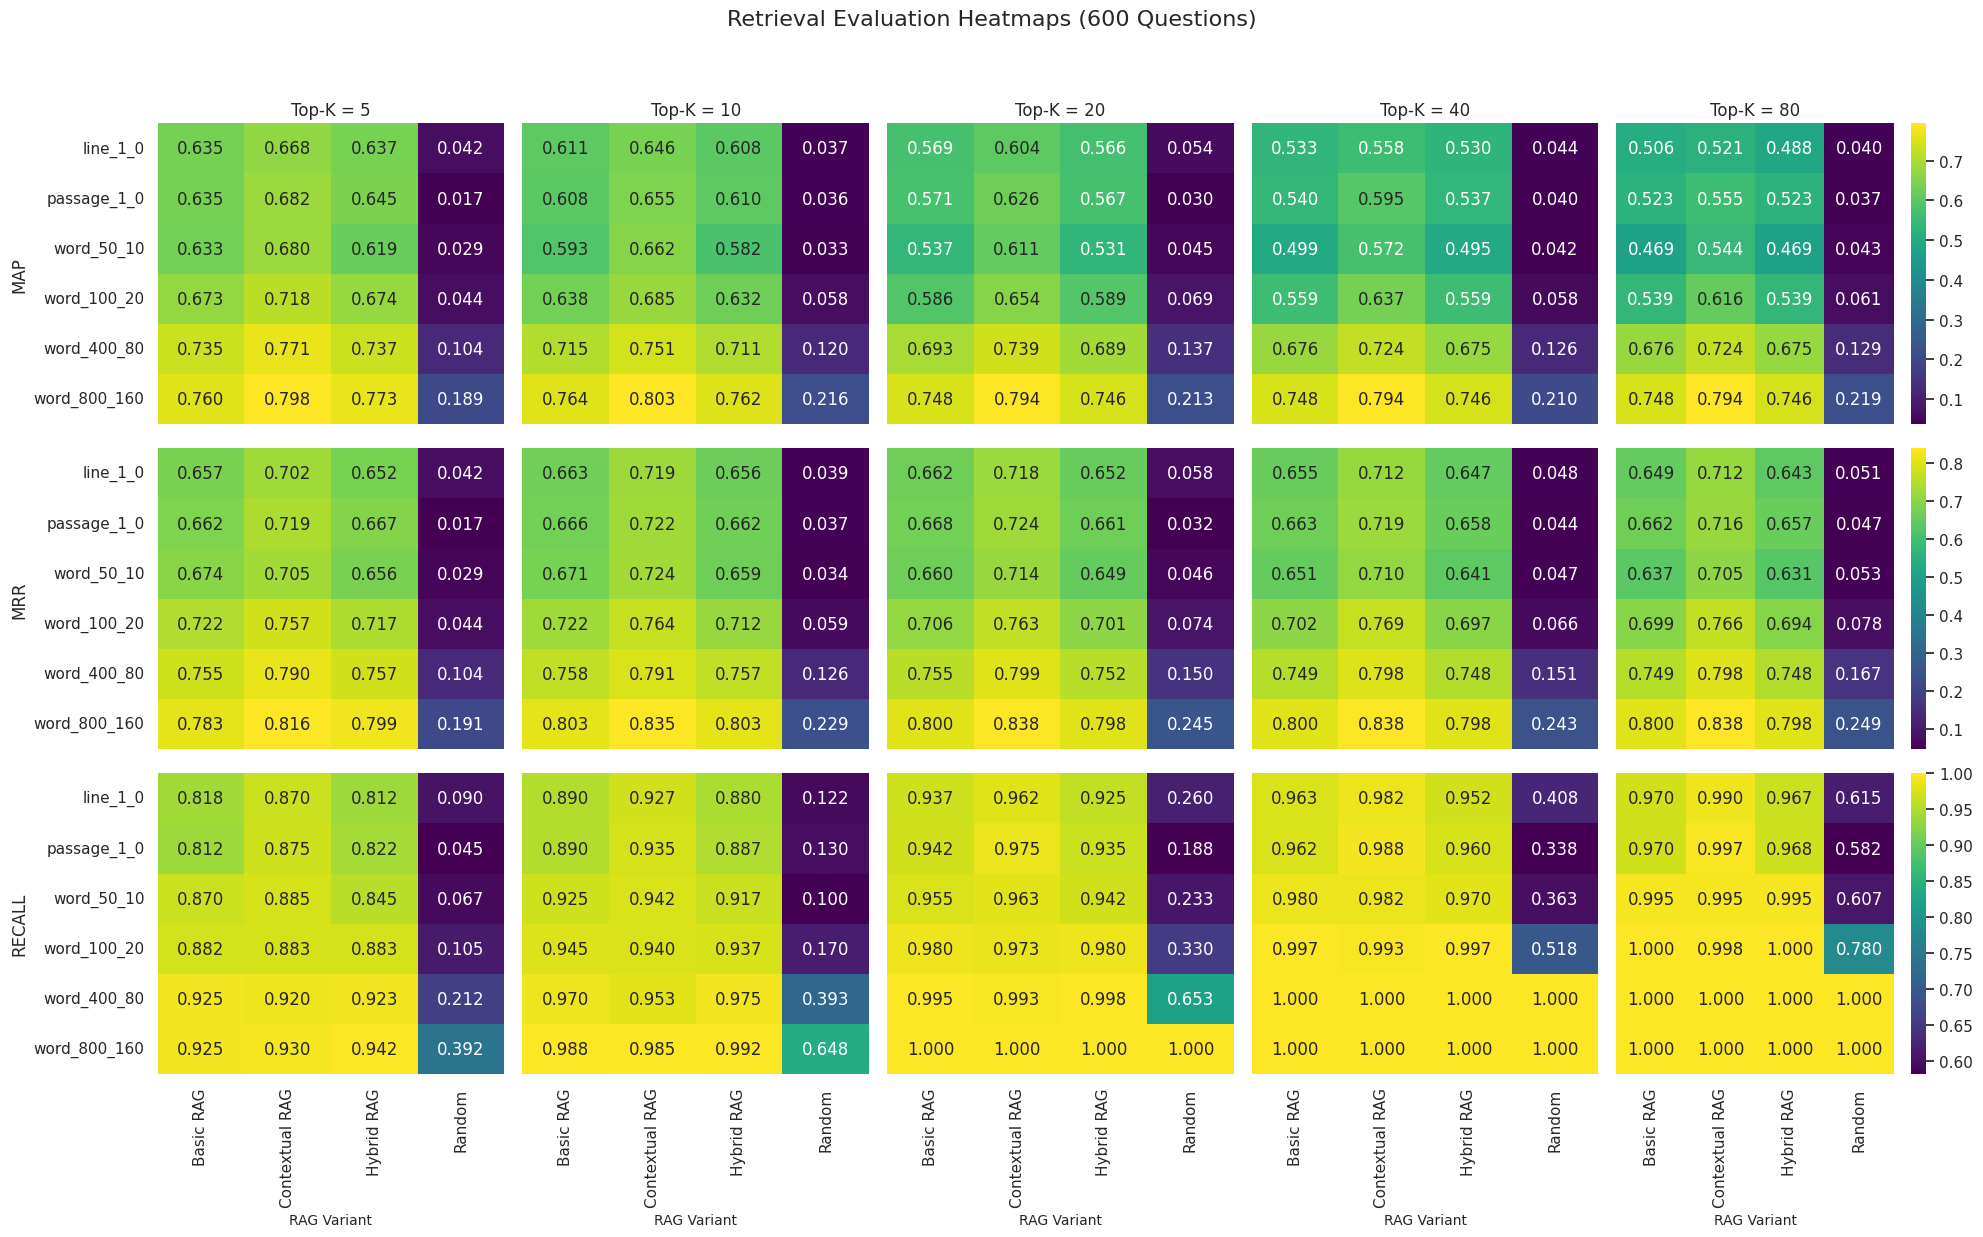

In [2]:
import os
import glob
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ─── CONFIG ────────────────────────────────────────────────────────────────────
BASE_DIR        = "results/retrieval/2025-07-04_15-42-39/QwenQwen3-Embedding-4B"
PATTERN         = os.path.join(BASE_DIR, "docs_*", "topk_*.pkl")
METRICS         = ["map", "mrr", "recall"]
CMAP            = "viridis"

# ← Define your exact splitting‐row order here: ←
SPLITTING_ORDER = [
    "line_1_0",
    "passage_1_0",
    "word_50_10",
    "word_100_20",
    "word_400_80",
    "word_800_160",
]
# ─── END CONFIG ────────────────────────────────────────────────────────────────

# 1) Gather all records
records = []
for fp in glob.glob(PATTERN):
    splitting = os.path.basename(os.path.dirname(fp)).removeprefix("docs_")
    m = re.search(r"topk_(\d+)\.pkl$", fp)
    if not m:
        continue
    topk = int(m.group(1))
    df   = pd.read_pickle(fp)

    # detect which prefixes have all three metrics
    prefixes = {
        col.rsplit("_",1)[0]
        for col in df.columns
        if any(col.endswith(f"_{m}") for m in METRICS)
    }
    prefixes = sorted(p for p in prefixes
                      if all(f"{p}_{metric}" in df.columns for metric in METRICS))

    def mean_col(s: pd.Series) -> float:
        clean = (
            s.dropna()
             .apply(lambda x: x[0] if isinstance(x,(list,tuple)) and len(x)==1 else x)
             .astype(float)
        )
        return clean.mean()

    for p in prefixes:
        for metric in METRICS:
            col = f"{p}_{metric}"
            records.append({
                "splitting": splitting,
                "topk"     : topk,
                "rag_type" : p,
                "metric"   : metric,
                "score"    : mean_col(df[col]) if col in df.columns else None
            })

results = pd.DataFrame(records)

# 2) Determine unique Top-K values
topks = sorted(results["topk"].unique())
rag_types = sorted(results["rag_type"].unique())

# 3) Enforce your splitting‐order (dropping any missing ones)
splittings = [s for s in SPLITTING_ORDER if s in results["splitting"].unique()]

# 4) Plot grid of heatmaps: rows=metrics, cols=topk
sns.set(style="whitegrid")
fig, axes = plt.subplots(
    nrows=len(METRICS),
    ncols=len(topks),
    figsize=(4 * len(topks), 4 * len(METRICS)),
    sharex="col",
    sharey="row"
)
axes = np.atleast_2d(axes)

for i, metric in enumerate(METRICS):
    for j, tk in enumerate(topks):
        ax = axes[i, j]
        sub = results[(results.metric == metric) & (results.topk == tk)]

        # pivot then reindex rows in your desired order
        pivot = sub.pivot_table(
            index="splitting",
            columns="rag_type",
            values="score",
            aggfunc="mean"
        ).reindex(index=splittings, columns=rag_types)

        if pivot.empty or pivot.isna().all().all():
            ax.axis("off")
            continue

        sns.heatmap(
            pivot,
            annot=True,
            fmt=".3f",
            cmap=CMAP,
            cbar=(j == len(topks)-1),
            ax=ax
        )
        if i == 0:
            ax.set_title(f"Top-K = {tk}", fontsize=12)
        if j == 0:
            ax.set_ylabel(metric.upper(), fontsize=12)
        else:
            ax.set_ylabel("")
        if i == len(METRICS)-1:
            ax.set_xlabel("RAG Variant", fontsize=10)
        else:
            ax.set_xlabel("")

first_fp = next(iter(glob.glob(PATTERN)), None)
row_count = None
if first_fp:
    try:
        first_df = pd.read_pickle(first_fp)

        # Get all prefixes that have all metric columns
        prefixes = {
            col.rsplit("_", 1)[0]
            for col in first_df.columns
            if all(f"{col.rsplit('_', 1)[0]}_{metric}" in first_df.columns for metric in METRICS)
        }

        # Build full set of metric column names
        metric_cols = [
            f"{prefix}_{metric}"
            for prefix in prefixes
            for metric in METRICS
        ]

        # Drop rows where *any* of those columns are NaN
        row_count = first_df.dropna(subset=metric_cols).shape[0]

    except Exception as e:
        print(f"Warning: Could not load or process {first_fp}: {e}")
if row_count is not None:
    fig.suptitle(f"Retrieval Evaluation Heatmaps ({row_count} Questions)", fontsize=16, y=1.03)
    
plt.tight_layout()
plt.show()

In [3]:
import glob
import os
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

BASE_DIR = "results/retrieval/2025-06-27_14-16-40/QwenQwen3-Embedding-4B"
PATTERN = os.path.join(BASE_DIR, "docs_*", "topk_*.pkl")

all_dfs = []

for fp in glob.glob(PATTERN):
    print(f"Processing: {fp}")
    df = pd.read_pickle(fp)
    print("  Columns:", list(df.columns))
    
    # Find Contextual RAG columns
    contextual_cols = [col for col in df.columns if col.startswith("Basic RAG_")]
    print("  Contextual cols:", contextual_cols)
    
    if not contextual_cols:
        print("  Skipping because no contextual columns found.")
        continue
    
    if "variant" not in df.columns:
        print("  Skipping because 'variant' column not found.")
        continue
    
    # Extract Top-K from file name
    m = re.search(r"topk_(\d+)\.pkl$", fp)
    topk = int(m.group(1)) if m else None
    
    sub_df = df[contextual_cols + ["variant"]].copy()
    sub_df["source_file"] = os.path.basename(fp)
    sub_df["topk"] = topk
    all_dfs.append(sub_df)

print(f"\n✅ Loaded {len(all_dfs)} DataFrames.")

if not all_dfs:
    print("❌ No data loaded. Check your patterns or column names.")
else:
    contextual_data = pd.concat(all_dfs, ignore_index=True)
    print(f"✅ contextual_data shape: {contextual_data.shape}")

    # Melt into long format
    melted = contextual_data.melt(
        id_vars=["variant", "source_file", "topk"],
        var_name="metric",
        value_name="score"
    )

    # Clean metric names
    melted["metric"] = melted["metric"].str.replace("Contextual RAG_", "")
    
    melted = melted.dropna(subset=["score"])
    print(melted.head())

Processing: results/retrieval/2025-06-27_14-16-40/QwenQwen3-Embedding-4B/docs_word_768_160/topk_20.pkl
  Columns: ['question', 'references', 'groundTruth', 'source_file', 'documents', 'variant', 'prev_messages', 'Random_map', 'Random_mrr', 'Random_recall', 'Basic RAG_map', 'Basic RAG_mrr', 'Basic RAG_recall', 'Hybrid RAG_map', 'Hybrid RAG_mrr', 'Hybrid RAG_recall', 'Contextual RAG_map', 'Contextual RAG_mrr', 'Contextual RAG_recall']
  Contextual cols: ['Basic RAG_map', 'Basic RAG_mrr', 'Basic RAG_recall']
Processing: results/retrieval/2025-06-27_14-16-40/QwenQwen3-Embedding-4B/docs_word_768_160/topk_5.pkl
  Columns: ['question', 'references', 'groundTruth', 'source_file', 'documents', 'variant', 'prev_messages', 'Random_map', 'Random_mrr', 'Random_recall', 'Basic RAG_map', 'Basic RAG_mrr', 'Basic RAG_recall', 'Hybrid RAG_map', 'Hybrid RAG_mrr', 'Hybrid RAG_recall', 'Contextual RAG_map', 'Contextual RAG_mrr', 'Contextual RAG_recall']
  Contextual cols: ['Basic RAG_map', 'Basic RAG_mrr',

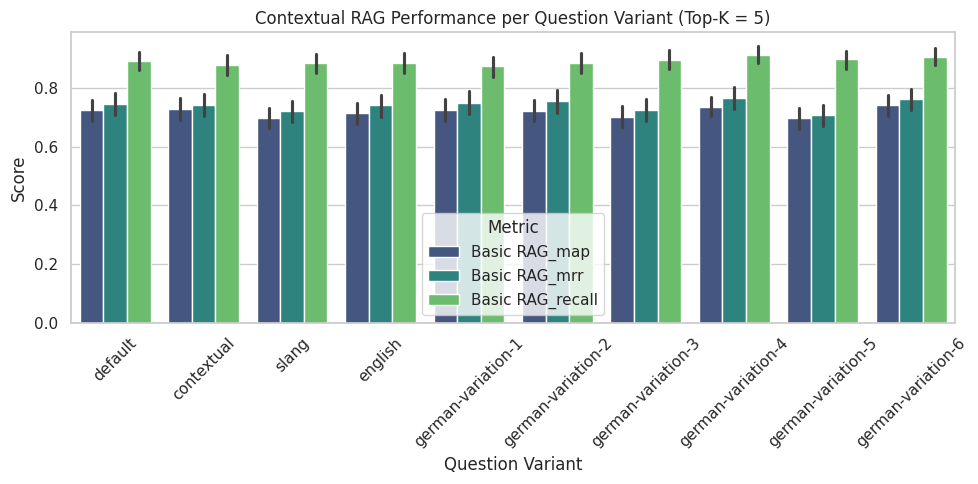

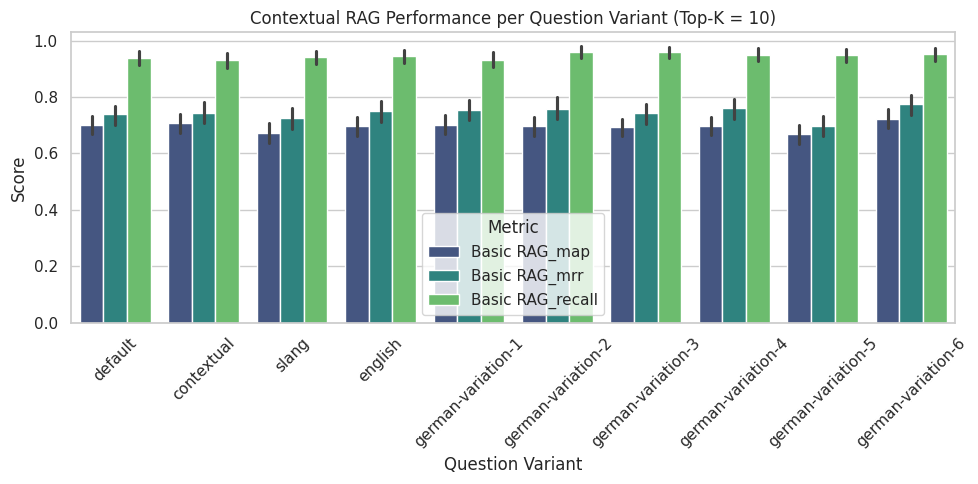

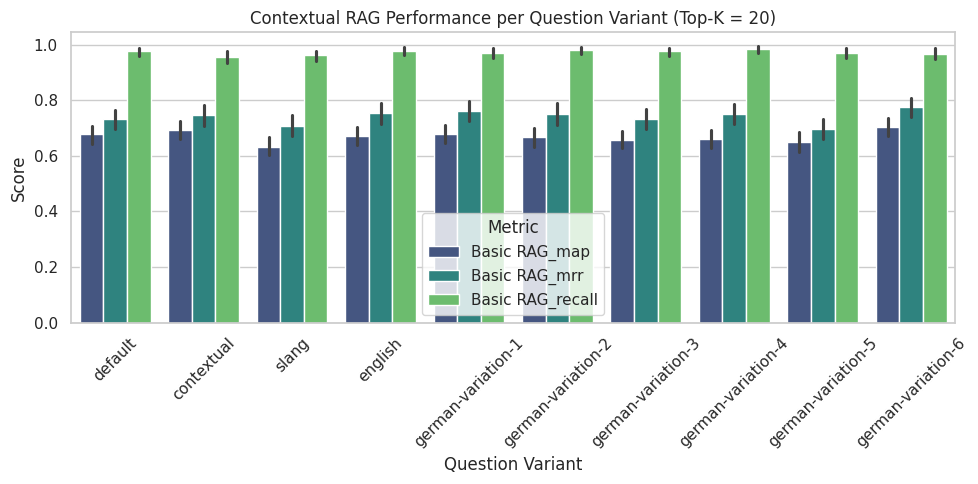

In [4]:
for tk in sorted(melted["topk"].unique()):
    subset = melted[melted["topk"] == tk]

    plt.figure(figsize=(10, 5))
    sns.barplot(
        data=subset,
        x="variant",
        y="score",
        hue="metric",
        estimator="mean",
        errorbar="ci",
        palette="viridis"
    )
    plt.title(f"Contextual RAG Performance per Question Variant (Top-K = {tk})")
    plt.ylabel("Score")
    plt.xlabel("Question Variant")
    plt.xticks(rotation=45)
    plt.legend(title="Metric")
    plt.tight_layout()
    plt.show()

In [5]:
import glob
import os
import pandas as pd
import re

BASE_DIR = "results/retrieval/2025-06-27_14-16-40/QwenQwen3-Embedding-4B"
PATTERN = os.path.join(BASE_DIR, "docs_*", "topk_*.pkl")

contextual_questions = []

for fp in glob.glob(PATTERN):
    df = pd.read_pickle(fp)

    if "variant" not in df.columns:
        continue
    
    if "question" not in df.columns:
        continue

    # Filter only contextual rows
    sub_df = df[df["variant"] == "contextual"]

    if not sub_df.empty:
        # Optionally track the file the questions came from
        for q in sub_df["question"]:
            contextual_questions.append({
                "source_file": os.path.basename(fp),
                "question": q
            })

# Convert to DataFrame for pretty printing (optional)
contextual_df = pd.DataFrame(contextual_questions)

if contextual_df.empty:
    print("No contextual questions found.")
else:
    # Print all contextual questions
    print("✅ Contextual Questions:\n")
    for idx, row in contextual_df.iterrows():
        print(f"- ({row['source_file']}) {row['question']}")

✅ Contextual Questions:

- (topk_20.pkl) Und wie lange dauert dieser Eingriff normalerweise?
- (topk_20.pkl) Ja, der Arzt hat gesagt, das Baby liegt in Beckenendlage. Kann man die Wendung dann sofort versuchen oder muss ich noch warten?
- (topk_20.pkl) Könnte so ein Risiko auch bedeuten, dass dann ein Kaiserschnitt notwendig wird?
- (topk_20.pkl) Sind diese Methoden denn sicher und werden sie oft in Krankenhäusern angewendet?
- (topk_20.pkl) Und wie erkennt man genau, ob solche Komplikationen vorliegen?
- (topk_20.pkl) Beeinflussen bestimmte Risikofaktoren die Erfolgschancen bei meinem Fall?
- (topk_20.pkl) Gibt es Möglichkeiten, die Schmerzen während der Wendung zu verringern?
- (topk_20.pkl) Wird dann sofort ein Kaiserschnitt gemacht oder gibt es noch andere Möglichkeiten?
- (topk_20.pkl) Gibt es dann besondere Risiken für mein Baby bei der Wendung?
- (topk_20.pkl) Ja, der Eingriff ist morgen früh, ab wann darf ich nichts mehr zu mir nehmen?
- (topk_20.pkl) Können diese Atemprobleme 

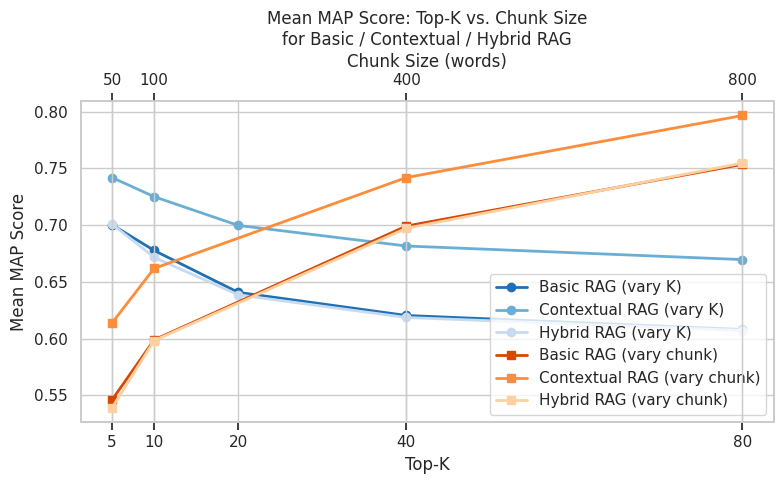

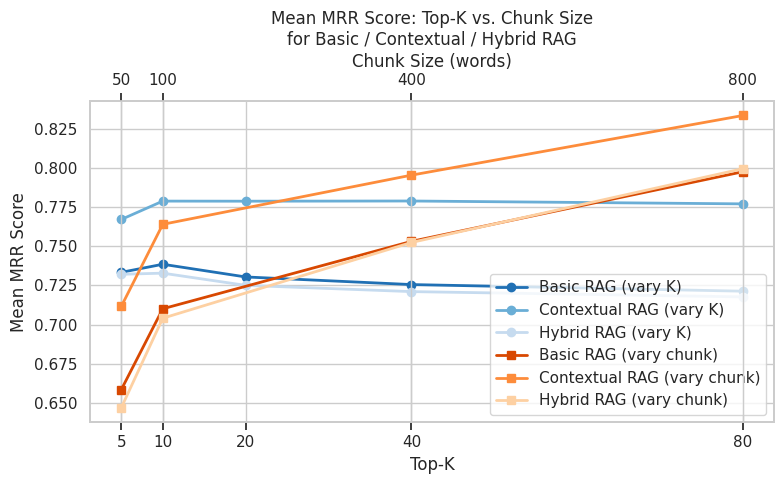

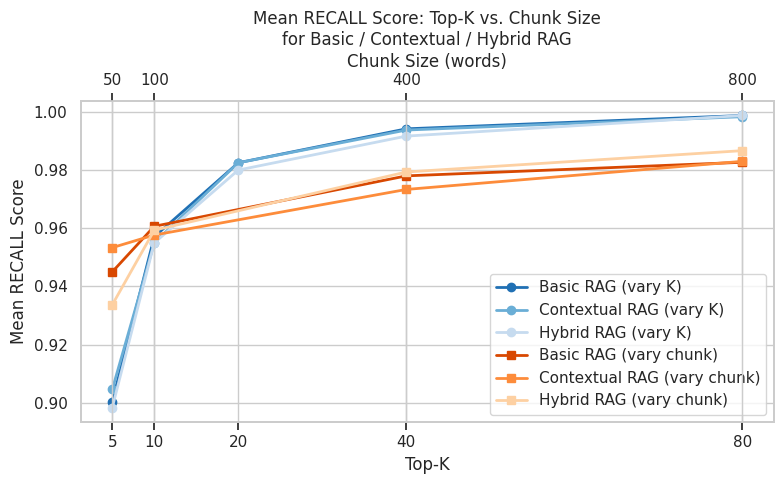

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ─── CONFIG ────────────────────────────────────────────────────────────────────
METRICS   = ["map", "mrr", "recall"]
rag_types = ["Basic RAG", "Contextual RAG", "Hybrid RAG"]
# ─── PREP ──────────────────────────────────────────────────────────────────────

df = (
    results
    .query("rag_type in @rag_types")
    .loc[lambda d: d.splitting.str.startswith("word_")]
    .copy()
)
df["chunk_size"] = df["splitting"].str.extract(r"word_(\d+)_")[0].astype(int)
df["xpos"]       = df["chunk_size"] / 10

topk_palette  = sns.color_palette("Blues",   n_colors=3)[::-1]
chunk_palette = sns.color_palette("Oranges", n_colors=3)[::-1]
topk_colors   = dict(zip(rag_types, topk_palette))
chunk_colors  = dict(zip(rag_types, chunk_palette))

# ─── PLOTTING ───────────────────────────────────────────────────────────────────
for metr in METRICS:
    fig, ax1 = plt.subplots(figsize=(8, 5))

    # Bottom axis: vary Top-K (solid ●)
    for rt in rag_types:
        sub = df[(df.metric == metr) & (df.rag_type == rt)]
        agg = sub.groupby("topk")["score"].mean().reset_index()
        ax1.plot(
            agg["topk"], agg["score"],
            marker="o",
            color=topk_colors[rt],
            linewidth=2,
            label=f"{rt} (vary K)"
        )
    ax1.set_xlabel("Top-K")
    ax1.set_ylabel(f"Mean {metr.upper()} Score")
    ax1.set_xticks(sorted(df["topk"].unique()))

    # Top axis: vary chunk size (solid ■)
    ax2 = ax1.twiny()
    for rt in rag_types:
        sub = df[(df.metric == metr) & (df.rag_type == rt)]
        agg = sub.groupby("xpos")["score"].mean().reset_index()
        ax2.plot(
            agg["xpos"], agg["score"],
            marker="s",
            color=chunk_colors[rt],
            linewidth=2,
            label=f"{rt} (vary chunk)"
        )
    ax2.set_xlabel("Chunk Size (words)")
    xpos = sorted(df["xpos"].unique())
    ax2.set_xticks(xpos)
    ax2.set_xticklabels((pd.Series(xpos) * 10).astype(int).tolist())

    # Combined legend
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1 + h2, l1 + l2, loc="lower right")

    plt.title(f"Mean {metr.upper()} Score: Top-K vs. Chunk Size\nfor Basic / Contextual / Hybrid RAG")
    plt.tight_layout()
    plt.show()

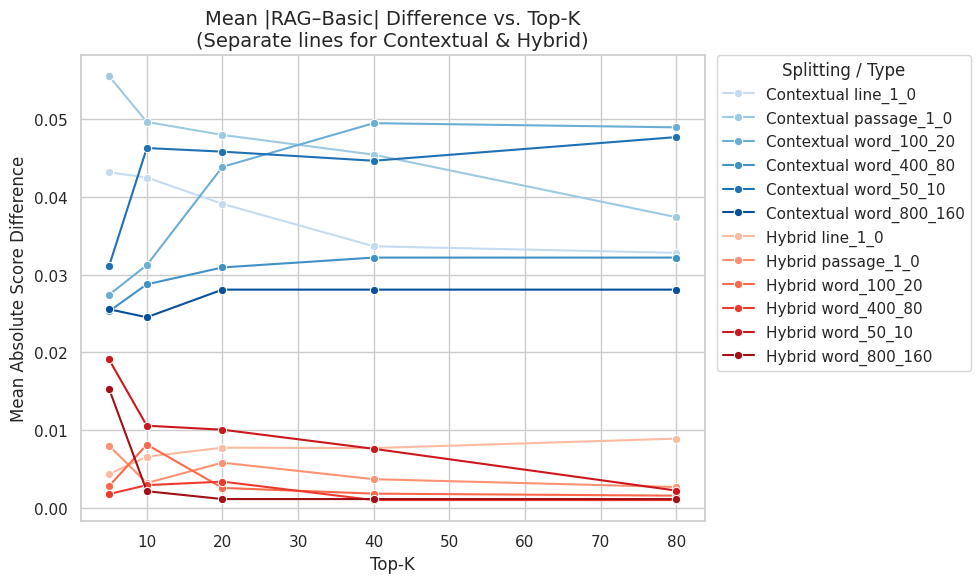

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# ─── CONFIG ────────────────────────────────────────────────
METRICS    = ["map","mrr","recall"]
splittings = sorted(results["splitting"].unique())
sns.set(style="whitegrid")

# ─── 0) Pivot long → wide, so we have basic/contextual/hybrid columns ─────────
wide = (
    results
      .pivot_table(
         index=["splitting","topk"],
         columns=["rag_type","metric"],
         values="score"
      )
)
wide.columns = [f"{rt}_{m}" for rt, m in wide.columns]  # flatten
wide = wide.reset_index()

# ─── 1) Compute diff_contextual_<m> & diff_hybrid_<m> ───────────────────────
for m in METRICS:
    wide[f"diff_contextual_{m}"] = (
        wide[f"Contextual RAG_{m}"] - wide[f"Basic RAG_{m}"]
    )
    wide[f"diff_hybrid_{m}"] = (
        wide[f"Hybrid RAG_{m}"]     - wide[f"Basic RAG_{m}"]
    )

# ─── 2) Melt out all the diffs and extract type ──────────────────────────────
diff_cols = [c for c in wide.columns if c.startswith("diff_")]
df_diff = (
    wide
      .melt(
         id_vars=["splitting","topk"],
         value_vars=diff_cols,
         var_name="diff_metric",
         value_name="diff_score"
      )
      .dropna(subset=["diff_score"])
)
# pull out “contextual” vs “hybrid”
df_diff["diff_type"] = df_diff["diff_metric"].str.extract(r"diff_(contextual|hybrid)_")
df_diff["abs_diff"]  = df_diff["diff_score"].abs()

# ─── 3) Aggregate across metrics ─────────────────────────────────────────────
agg = (
    df_diff
      .groupby(["topk","diff_type","splitting"])["abs_diff"]
      .mean()
      .reset_index()
)

# build a grouping key for the legend
agg["group"] = agg["diff_type"].str.title() + " " + agg["splitting"]

# ─── 4) Build a palette: 6 blues for contextual, 6 reds for hybrid ──────────
blues = sns.color_palette("Blues",  len(splittings)+1)[1:]  # skip the palest
reds  = sns.color_palette("Reds",   len(splittings)+1)[1:]

palette = {}
for i, s in enumerate(splittings):
    palette[f"Contextual {s}"] = blues[i]
    palette[f"Hybrid {s}"]     = reds[i]

# ─── 5) Plot all 12 lines ───────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(
    data=agg,
    x="topk",
    y="abs_diff",
    hue="group",
    palette=palette,
    marker="o",
    ax=ax
)

ax.set_title("Mean |RAG–Basic| Difference vs. Top-K\n(Separate lines for Contextual & Hybrid)", fontsize=14)
ax.set_xlabel("Top-K")
ax.set_ylabel("Mean Absolute Score Difference")
ax.legend(title="Splitting / Type", bbox_to_anchor=(1.02,1), loc="upper left", borderaxespad=0)
plt.tight_layout()
plt.show()

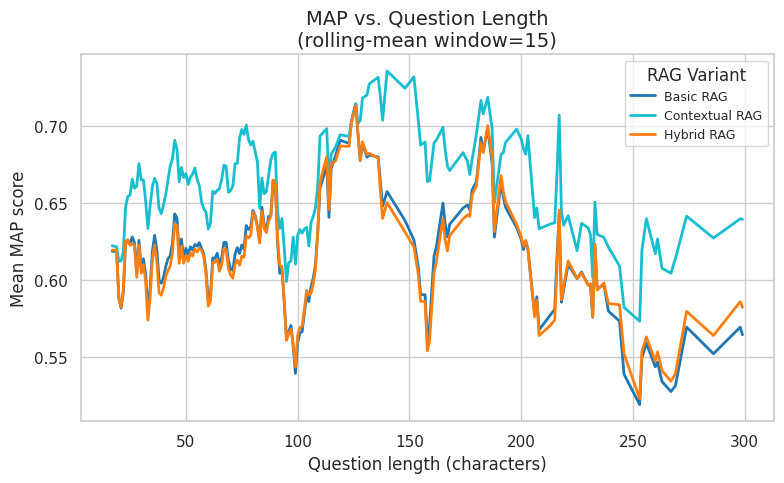

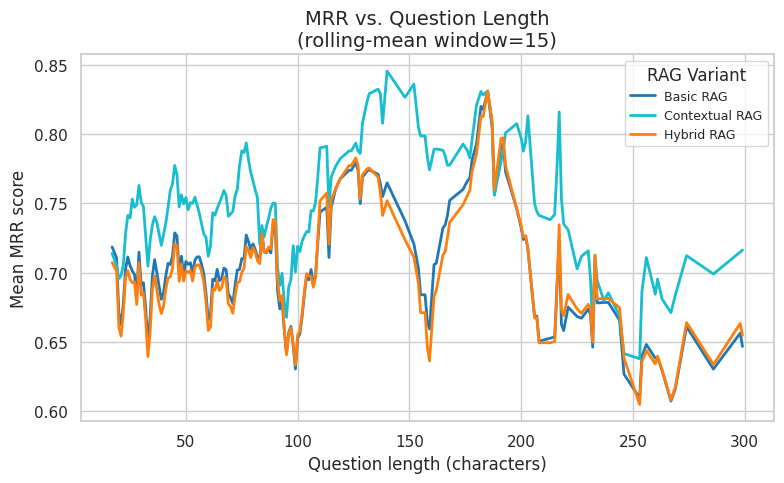

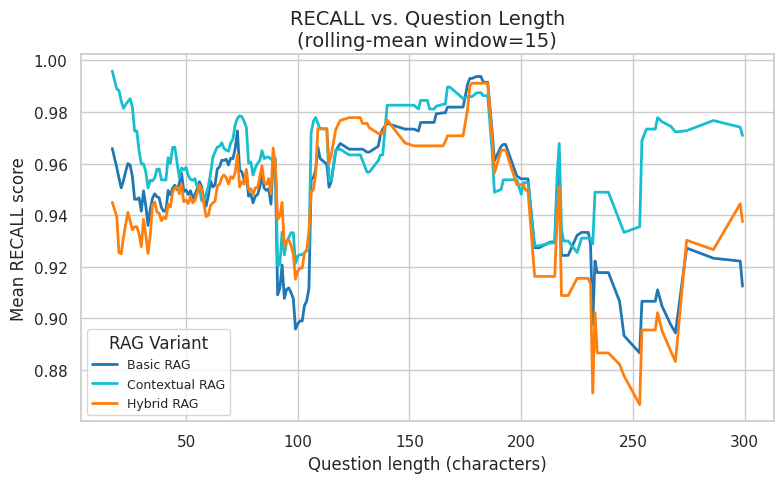

In [8]:
import os
import glob
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ─── CONFIG ───────────────────────────────────────────────────────────
BASE_DIR = "results/retrieval/2025-07-04_15-42-39/QwenQwen3-Embedding-4B"
PATTERN  = os.path.join(BASE_DIR, "docs_*", "topk_*.pkl")
METRICS  = ["map","mrr","recall"]
sns.set(style="whitegrid")
# ─── BUILD `long` AS BEFORE ────────────────────────────────────────────
records = []
for fp in glob.glob(PATTERN):
    splitting = os.path.basename(os.path.dirname(fp)).removeprefix("docs_")
    df = pd.read_pickle(fp)

    prefixes = {
        col.rsplit("_",1)[0]
        for col in df.columns
        if any(col.endswith(f"_{m}") for m in METRICS)
    }
    prefixes = sorted(p for p in prefixes
                      if all(f"{p}_{m}" in df.columns for m in METRICS))

    for p in prefixes:
        for m in METRICS:
            col = f"{p}_{m}"
            if col not in df: 
                continue
            series = (
                df[col]
                  .dropna()
                  .apply(lambda x: x[0] if isinstance(x,(list,tuple)) and len(x)==1 else x)
                  .astype(float)
            )
            for q, score in zip(df["question"], series):
                records.append({
                    "rag_type": p,            # e.g. "Basic RAG","Contextual RAG","Hybrid RAG","Random"
                    "metric"  : m,
                    "char_len": len(q),
                    "score"   : score
                })

long = pd.DataFrame(records)

# ─── AGGREGATE & FILTER OUT RANDOM ────────────────────────────────────────
agg2 = (
    long
    .groupby(["char_len","rag_type","metric"])["score"]
    .mean()
    .reset_index()
)
agg2 = agg2[agg2.rag_type != "Random"]  # drop the Random variant

# ─── PALETTE (no Random) & SMOOTHING WINDOW ─────────────────────────────
palette = {
    "Basic RAG"     : "tab:blue",
    "Contextual RAG": "tab:cyan",
    "Hybrid RAG"    : "tab:orange",
}
SMOOTH_WINDOW = 15

# ─── PLOT ONE SMOOTHED LINE PER RAG VARIANT ──────────────────────────────
for metric in METRICS:
    dfm = agg2[agg2.metric == metric]
    fig, ax = plt.subplots(figsize=(8,5))

    for rag_type, sub in dfm.groupby("rag_type"):
        sub = sub.sort_values("char_len")
        sub["smooth_score"] = (
            sub["score"]
            .rolling(window=SMOOTH_WINDOW, min_periods=1, center=True)
            .mean()
        )
        ax.plot(
            sub["char_len"],
            sub["smooth_score"],
            label=rag_type,
            color=palette[rag_type],
            linewidth=2
        )

    ax.set_title(f"{metric.upper()} vs. Question Length\n(rolling‐mean window={SMOOTH_WINDOW})", fontsize=14)
    ax.set_xlabel("Question length (characters)")
    ax.set_ylabel(f"Mean {metric.upper()} score")
    ax.legend(title="RAG Variant", loc="best", fontsize=9)
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_958703/1109064216.py:119: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


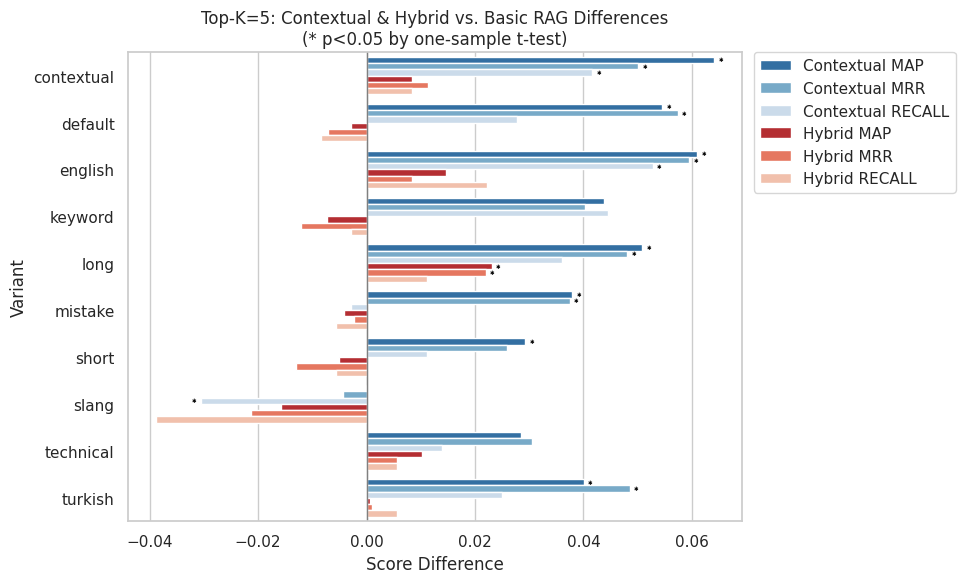

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import ttest_1samp
import os
import glob
import re

# ─── CONFIG ────────────────────────────────────────────────────────────────────
BASE_DIR = "results/retrieval/2025-07-04_15-42-39/QwenQwen3-Embedding-4B"
PATTERN  = os.path.join(BASE_DIR, "docs_*", "topk_*.pkl")
METRICS  = ["map", "mrr", "recall"]
# ─── END CONFIG ────────────────────────────────────────────────────────────────

def mean_col(s: pd.Series) -> float:
    """Flatten singleton lists/tuples then take float-mean."""
    clean = (
        s.dropna()
         .apply(lambda x: x[0] if isinstance(x, (list,tuple)) and len(x)==1 else x)
         .astype(float)
    )
    return clean.mean()

# 1) Gather everything into one DataFrame of per-variant scores
records = []
for fp in glob.glob(PATTERN):
    m = re.search(r"topk_(\d+)\.pkl$", fp)
    if not m:
        continue
    topk = int(m.group(1))
    df   = pd.read_pickle(fp)

    if "variant" not in df.columns:
        continue

    for variant, grp in df.groupby("variant"):
        rec = {
            "variant": variant,
            "topk"   : topk,
        }
        # for each metric, grab Basic/Contextual/Hybrid
        for metric in METRICS:
            for kind in ["Basic RAG", "Contextual RAG", "Hybrid RAG"]:
                col = f"{kind}_{metric}"
                rec[f"{kind.replace(' ', '_').lower()}_{metric}"] = (
                    mean_col(grp[col]) if col in grp.columns else np.nan
                )
        records.append(rec)

results = pd.DataFrame(records)

# 2) Compute differences vs Basic
for metric in METRICS:
    results[f"diff_contextual_{metric}"] = (
        results[f"contextual_rag_{metric}"] - results[f"basic_rag_{metric}"]
    )
    results[f"diff_hybrid_{metric}"] = (
        results[f"hybrid_rag_{metric}"] - results[f"basic_rag_{metric}"]
    )

# Keep ordering
variants = sorted(results["variant"].unique())
topks    = sorted(results["topk"].unique())

# 3) Melt into long form for easy plotting
diff_cols = [f"diff_contextual_{m}" for m in METRICS] + \
            [f"diff_hybrid_{m}"   for m in METRICS]

melted = (
    results
    .melt(
        id_vars=["variant", "topk"],
        value_vars=diff_cols,
        var_name="diff_type_metric",
        value_name="diff_score"
    )
    .dropna(subset=["diff_score"])
)
# split into two columns: diff_type (contextual/hybrid) and metric
melted[["diff_type","metric"]] = (
    melted["diff_type_metric"]
      .str
      .extract(r"diff_(contextual|hybrid)_(.*)")
)



# 1) Prepare data
sub = (
    melted
    .query("topk == 5 and diff_type in ['contextual','hybrid']")
    .copy()
)
sub['diff_type'] = sub['diff_type'].str.title()
sub['metric']    = sub['metric'].str.upper()
sub['key']       = sub['diff_type'] + ' ' + sub['metric']

# 2) Compute significance
sig = {}
for (variant, dt, metr), grp in sub.groupby(['variant','diff_type','metric']):
    _, p = ttest_1samp(grp['diff_score'], 0)
    sig[(variant, dt, metr)] = (p < 0.05)

# 3) Build palette & hue_order
metrics   = ["MAP","MRR","RECALL"]
blues  = sns.color_palette("Blues",  3)[::-1]
reds   = sns.color_palette("Reds",   3)[::-1]

palette = {f"Contextual {m}": blues[i] for i,m in enumerate(metrics)}
palette.update({f"Hybrid {m}": reds[i]     for i,m in enumerate(metrics)})

hue_order = [f"Contextual {m}" for m in metrics] + [f"Hybrid {m}" for m in metrics]
variants  = sorted(sub['variant'].unique())

# 4) Plot
fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(
    data=sub,
    y="variant",
    x="diff_score",
    hue="key",
    hue_order=hue_order,
    palette=palette,
    ci=None,
    order=variants,
    ax=ax
)

# zero‐line
ax.axvline(0, color="gray", linewidth=1)

# annotate significance per container (hue)
for hue_idx, container in enumerate(ax.containers):
    key = hue_order[hue_idx]             # e.g. "Contextual MAP"
    dt, metr = key.split()               # "Contextual","MAP"
    metr = metr.upper()

    for bar_idx, bar in enumerate(container.patches):
        variant = variants[bar_idx]      # same order as y-axis
        if not sig.get((variant, dt, metr), False):
            continue

        x = bar.get_width()
        y = bar.get_y() + bar.get_height()/2

        # small offset in points
        dx = 3 if x >= 0 else -3

        ax.annotate(
            "✱",
            xy=(x, y),
            xytext=(dx, 0),
            textcoords="offset points",
            ha="left" if x >= 0 else "right",
            va="center",
            fontsize=4,
            color="black"
        )

# move legend outside
ax.legend(
    title="",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    borderaxespad=0
)

ax.set_title(
    "Top-K=5: Contextual & Hybrid vs. Basic RAG Differences\n"
    "(* p<0.05 by one-sample t-test)"
)
ax.set_xlabel("Score Difference")
ax.set_ylabel("Variant")

plt.tight_layout()
plt.subplots_adjust(right=0.75)  # make room for the legend
plt.show()